<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/acrobot_ilqr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from autograd import jacobian
import autograd.numpy as anp

In [6]:
class Acrobot:
    def __init__(self):
        self.m1 = 1.0
        self.m2 = 1.0
        self.l1 = 1.0
        self.l2 = 1.0
        self.g = 9.81

    def dynamics(self, x, u):
        # Minimal dummy dynamics (replace with true model)
        theta1, theta2, dtheta1, dtheta2 = x
        torque = u if np.isscalar(u) else u[0]

        # Simple pendulum-like dummy model
        ddtheta1 = -self.g * anp.sin(theta1)
        ddtheta2 = torque - self.g * anp.sin(theta2)

        return np.array([dtheta1, dtheta2, ddtheta1, ddtheta2])


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
/tmp/ipython-input-20-2316658835.py:127: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  un[k] = utraj[k] - alpha * d[k] - K[:, :, k] @ (xn[:, k] - xtraj[:, k])
/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
/tmp/ipython-input-20-2316658835.py:127: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  un[k] = utraj[k] - alpha * d[k] - K[:, :, k] @ (xn[:, k] - xtraj[:, k]

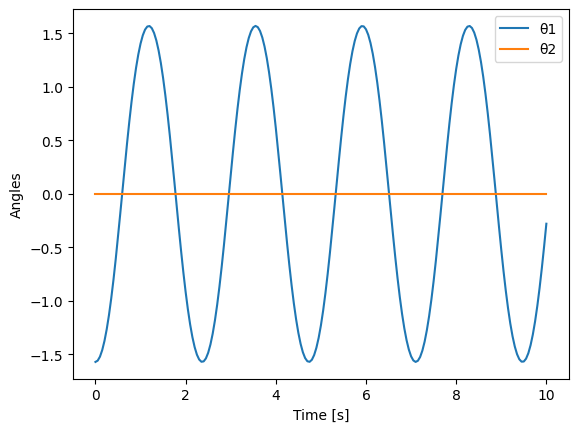

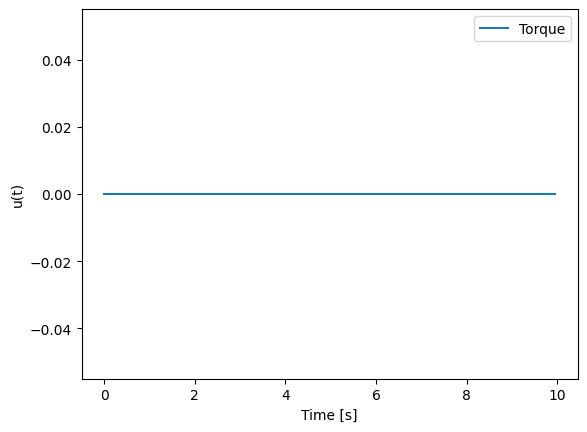

In [20]:
# Dynamics - Acrobot from RobotZoo equivalent
# from robot_dynamics import Acrobot  # Assuming equivalent custom module
from scipy.linalg import block_diag

# Define model and parameters
acrobot = Acrobot()
h = 0.05

def dynamics_rk4(x, u):
    f1 = acrobot.dynamics(x, u)
    f2 = acrobot.dynamics(x + 0.5 * h * f1, u)
    f3 = acrobot.dynamics(x + 0.5 * h * f2, u)
    f4 = acrobot.dynamics(x + h * f3, u)
    return x + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)

# Jacobians via autograd
def dfdx(x, u):
    return jacobian(lambda _x: dynamics_rk4(_x, u))(x)

# def dfdu(x, u):
#     return jacobian(lambda _u: dynamics_rk4(x, _u))(u)

def dfdu(x, u):
    u = anp.atleast_1d(u)  # Ensure u is a 1D array
    return jacobian(lambda u_: dynamics_rk4(x, u_))(u)

# Problem setup
Nx = 4
Nu = 1
Tfinal = 10.0
Nt = int(Tfinal / h) + 1
thist = np.arange(0, h * Nt, h)

Q = np.diag([1.0, 1.0, 0.1, 0.1])
R = 0.01
Qn = 100 * np.eye(Nx)

x0 = np.array([-np.pi / 2, 0, 0, 0])
xgoal = np.array([np.pi / 2, 0, 0, 0])

xtraj = np.tile(x0[:, None], (1, Nt))
utraj = np.random.randn(Nt - 1)

def stage_cost(x, u):
    dx = x - xgoal
    return 0.5 * dx.T @ Q @ dx + 0.5 * R * u**2

def terminal_cost(x):
    dx = x - xgoal
    return 0.5 * dx.T @ Qn @ dx

def cost(xtraj, utraj):
    J = 0
    for k in range(Nt - 1):
        J += stage_cost(xtraj[:, k], utraj[k])
    J += terminal_cost(xtraj[:, -1])
    return J

# Initial rollout
for k in range(Nt - 1):
    xtraj[:, k + 1] = dynamics_rk4(xtraj[:, k], utraj[k])
J = cost(xtraj, utraj)

# DDP initialization
p = np.zeros((Nx, Nt))
P = np.zeros((Nx, Nx, Nt))
d = np.ones(Nt - 1)
K = np.zeros((Nu, Nx, Nt - 1))
xn = np.zeros((Nx, Nt))
un = np.zeros(Nt - 1)

iter = 0
while np.max(np.abs(d)) > 1e-3:
    iter += 1
    p[:, -1] = Qn @ (xtraj[:, -1] - xgoal)
    P[:, :, -1] = Qn

    dJ = 0.0

    # Backward Pass
    for k in reversed(range(Nt - 1)):
        q = Q @ (xtraj[:, k] - xgoal)
        r = R * utraj[k]

        A = dfdx(xtraj[:, k], utraj[k])
        B = dfdu(xtraj[:, k], utraj[k]).reshape((Nx, Nu))

        gx = q + A.T @ p[:, k + 1]
        gu = r + B.T @ p[:, k + 1]

        Gxx = Q + A.T @ P[:, :, k + 1] @ A
        Guu = R + B.T @ P[:, :, k + 1] @ B
        Gxu = A.T @ P[:, :, k + 1] @ B
        Gux = Gxu.T

        gx = np.asarray(gx, dtype=np.float64)
        Gxx = np.asarray(Gxx, dtype=np.float64)
        Gxu = np.asarray(Gxu, dtype=np.float64)
        Guu = np.asarray(Guu, dtype=np.float64)
        Gux = np.asarray(Gux, dtype=np.float64)
        gu = np.asarray(gu, dtype=np.float64)

        d[k] = np.linalg.solve(Guu, gu)[0]
        if gu.shape[0] == 1:
            K[:, :, k] = (Gux / Guu)
            # p[:, k] = gx - K[:, :, k].T @ gu + K[:, :, k].T @ (Guu * d[k]) - Gxu * d[k]
            p[:, k] = (gx - (K[:, :, k].T @ gu).ravel()+ (K[:, :, k].T @ (Guu * d[k])).ravel()
                      - (Gxu * d[k]).ravel())


            P[:, :, k] = Gxx + K[:, :, k].T @ Guu @ K[:, :, k] - Gxu @ K[:, :, k] - K[:, :, k].T @ Gux

            dJ += gu[0] * d[k]

        else:
            K[:, :, k] = np.linalg.solve(Guu, Gux.T).T

            p[:, k] = gx - K[:, :, k].T @ gu + K[:, :, k].T @ Guu @ d[k] - Gxu @ d[k]
            P[:, :, k] = Gxx + K[:, :, k].T @ Guu @ K[:, :, k] - Gxu @ K[:, :, k] - K[:, :, k].T @ Gux

            dJ += gu.T @ d[k]

    # Forward Pass with Line Search
    xn[:, 0] = xtraj[:, 0]
    alpha = 1.0
    for k in range(Nt - 1):
        un[k] = utraj[k] - alpha * d[k] - K[:, :, k] @ (xn[:, k] - xtraj[:, k])
        xn[:, k + 1] = dynamics_rk4(xn[:, k], un[k])

    Jn = cost(xn, un)
    while np.isnan(Jn) or Jn > (J - 1e-2 * alpha * ΔJ):
        alpha *= 0.5
        xn[:, 0] = xtraj[:, 0]
        for k in range(Nt - 1):
            un[k] = utraj[k] - alpha * d[k] - K[:, :, k] @ (xn[:, k] - xtraj[:, k])
            xn[:, k + 1] = dynamics_rk4(xn[:, k], un[k])
        Jn = cost(xn, un)

    J = Jn
    xtraj = xn.copy()
    utraj = un.copy()

# Plotting
plt.figure()
plt.plot(thist, xtraj[0, :], label='θ1')
plt.plot(thist, xtraj[1, :], label='θ2')
plt.xlabel("Time [s]")
plt.ylabel("Angles")
plt.legend()

plt.figure()
plt.plot(thist[:-1], utraj, label='Torque')
plt.xlabel("Time [s]")
plt.ylabel("u(t)")
plt.legend()

plt.show()
